**Importing packages:**

In [44]:
%matplotlib inline
# standard import
import os
from datetime import date

# package imports
import numpy as np
import pandas as pd
import geopandas as gpd
import ssl
import datetime
from tqdm.notebook import tqdm as tqdm
from calendar import monthrange

# from IPython.display import set_matplotlib_formats
import matplotlib_inline.backend_inline

# plotting setup
from tueplots import bundles
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import plotly.express as px
import contextily as cx
import pyproj

# allow import of own scripts
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import own functions
from src.load_taxi_data import load_taxi_data
from src.taxi_zones_loader import taxi_zones_loader
from src.preprocess_data import preprocess_data
from src.keep_correct_year import keep_correct_year
from src.keep_correct_month import keep_correct_month
from src.remove_routes import remove_routes

# disable_certificate_check
ssl._create_default_https_context = ssl._create_unverified_context
# set matplotlib formats
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")
# make inline plots vector graphics

**Variables:**

In [45]:
# variables
DATA_PATH = '../dat/'
FIG_PATH = '../doc/fig/'

**Download all taxi data:**

In [46]:
# function to download all necessary data
def download_all_taxi_data():
    # download data for years between 2015 and 2021
    for year in range(2015, 2022):
        # download data for months between 01 and 12
        for month in tqdm(range(1, 13), desc="Downloading data from the year: %s"%(year)):
            # skip months after june 2021, because data is not available
            if not (year == 2021 and month >= 7):
                # leading zero if number as only one digit
                month = "%02d" % (month,)
                if os.path.isfile(DATA_PATH + 'df_taxi_%s_%s.csv'%(year, month)):
                    print("Dataset %s already downloaded."%'df_taxi_%s_%s.csv'%(year, month))
                else:
                    # download taxi data for given month and year
                    df_taxi = load_taxi_data(['yellow', 'green', 'fhv', 'fhvhv'], [int(year)], [int(month)])
                    # save data as csv on disk
                    df_taxi.to_csv('../dat/df_taxi_%s_%s.csv'%(year, month), encoding='utf-8')

**Calculate number of all trips over time:**

In [47]:
# calculate number of all trips over time
def calculate_number_of_all_trips_over_time():
    # create empty dataframe
    rides_df = pd.DataFrame(columns = ["time_period", "Yellow Taxi", "Green Taxi", "For-Hire Vehicle"])
    rides_ratio_df = pd.DataFrame(columns = ["time_period", "Yellow Taxi", "Green Taxi", "For-Hire Vehicle"])

    # download data for years between 2015 and 2021
    for year in range(2015, 2022): #for year in range(2015, 2022):
        # download data for months between 01 and 12
        for month in tqdm(range(1, 13), desc="Loading data from disk of year: %s"%(year)):
            # skip months after june 2021, because data is not available
            if not (year == 2021 and month >= 7):
                # leading zero if number as only one digit
                month = "%02d" % (month,)
                if os.path.isfile('../dat/df_taxi_%s_%s.csv'%(year, month)):
                    # read dataframe
                    df_taxi = pd.read_csv("../dat/df_taxi_%s_%s.csv"%(str(year), str(month)), index_col=[0])                
                    # get amount of days of month X in year Y
                    days = monthrange(int(year),int(month))[1]
                    # convert string into datetime format to only keep date
                    df_taxi['pickup_datetime'] = pd.to_datetime(df_taxi['pickup_datetime'], format='%Y-%m-%d').dt.date
                    # store date as string
                    df_taxi['pickup_datetime'] = df_taxi['pickup_datetime'].astype(str)
                    # for every day in the month
                    for day in range(1, days + 1):
                        # leading zero if number as only one digit
                        day = "%02d" % (day,)
                        # composite date from loop
                        date = '%s-%s-%s'%(year, month, day)
                        # filter by single day
                        df_taxi_subset = df_taxi[df_taxi['pickup_datetime'] == date]

                        # get total amount of rides
                        total = len(df_taxi_subset)
                        # get amount of yellow taxi rides
                        yellow_rides = df_taxi_subset.loc[df_taxi_subset.fleet == 'yellow', 'fleet'].count()
                        # get ratio of yellow taxi rides
                        yellow_rides_ratio = yellow_rides / total
                        # get amount of green taxi rides
                        green_rides = df_taxi_subset.loc[df_taxi_subset.fleet == 'green', 'fleet'].count()
                        # get ratio of green taxi rides
                        green_rides_ratio = green_rides / total
                        # get amount of vfh taxi rides
                        fhv_rides = df_taxi_subset.loc[df_taxi_subset.fleet == 'fhv', 'fleet'].count()
                        # get ratio of vfh taxi rides
                        fhv_rides_ratio = fhv_rides / total

                        rides_df = rides_df.append({'time_period': "%s/%s/%s"%(str(day), str(month), str(year)), 'Yellow Taxi': yellow_rides, 
                                                    'Green Taxi': green_rides, 'For-Hire Vehicle': fhv_rides}, ignore_index=True)
                        rides_ratio_df = rides_ratio_df.append({'time_period': "%s/%s/%s"%(str(day), str(month), str(year)), 'Yellow Taxi': yellow_rides_ratio, 
                                                    'Green Taxi': green_rides_ratio, 'For-Hire Vehicle': fhv_rides_ratio}, ignore_index=True)

                        del df_taxi_subset
                else:
                    print("File does not exist!")

    # save dataframes as csv
    rides_df.to_csv(DATA_PATH + 'rides_df.csv', encoding='utf-8')
    rides_ratio_df.to_csv(DATA_PATH + 'rides_ratio_df.csv', encoding='utf-8')

**Create and save plots:**

In [48]:
# create and save plots
def create_and_save_plots(rides_df, rides_ratio_df):
    # create own color map
    col_dict={1:"gold",
              2:"olivedrab", #yellowgreen
              3:"cornflowerblue"}
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # market share of taxi providers in NYC by month
    with plt.rc_context(bundles.neurips2021()):
        # initiate plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))#, constrained_layout=True)
        # do area plot
        rides_ratio_df.plot.area(x='time_period', ax=ax1, colormap=cm)
        # get yticks
        vals = ax1.get_yticks()
        # change y labels to percentage
        ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
        # set title
        ax1.set_title('Market share of taxi providers in NYC per month')
        # set x label
        ax1.set_xlabel('date')
        # set y label
        ax1.set_ylabel('ratio of market share')
        
        # do area plot
        rides_df.plot(x='time_period', ax=ax2, colormap=cm)
        # get yticks
        ax2.get_yaxis().get_major_formatter().set_scientific(False)
        # set title
        ax2.set_title('Taxi rides by provider in NYC per day')
        # set x label
        ax2.set_xlabel('date')
        # set y label
        ax2.set_ylabel('amount of rides')
        
        ax2.get_legend().remove()
        ax1.legend(facecolor='white', framealpha=1, loc=2, prop={'size': 8})
        
       
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=None)
        fig.autofmt_xdate()
        #fig.tight_layout()
        # show plot
        plt.show()
        # save figure
        fig.savefig(FIG_PATH + 'taxi-rides-over-time.pdf', bbox_inches='tight', dpi=400)

**Plotting:**

Will download... yellow_tripdata_2015-01.csv
Will download... green_tripdata_2015-01.csv


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


Will download... fhv_tripdata_2015-01.csv
Will download... fhvhv_tripdata_2015-01.csv
ERROR: There is no data available for fleet=fhvhv, years=[2015], months=[1]!
All necessary data are available.


Loading data from disk of year: 2015:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/f1/tnzvv5l54c36z9nn_dy7v_0c0000gn/T/ipykernel_83986/203285141.py:7: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  calculate_number_of_all_trips_over_time()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Number of all trips over time was calculated and were dataframes stored on disk.


/var/folders/f1/tnzvv5l54c36z9nn_dy7v_0c0000gn/T/ipykernel_83986/3315964734.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
/var/folders/f1/tnzvv5l54c36z9nn_dy7v_0c0000gn/T/ipykernel_83986/3315964734.py:41: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.24, hspace=None)


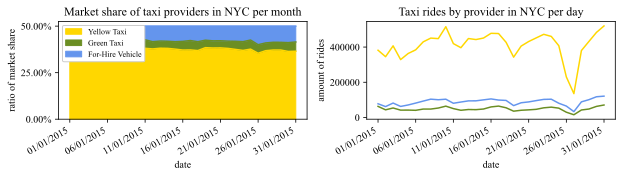

In [49]:
if os.path.isfile(DATA_PATH + 'rides_df.csv') and os.path.isfile(DATA_PATH + 'rides_ratio_df.csv'):
    print("Necessary calculations have already been made.")
else:
    download_all_taxi_data()
    print("All necessary data are available.")
    
    calculate_number_of_all_trips_over_time()
    print("Number of all trips over time was calculated and were dataframes stored on disk.")

rides_df = pd.read_csv(DATA_PATH + 'rides_df.csv', index_col=0)
rides_ratio_df = pd.read_csv(DATA_PATH + 'rides_ratio_df.csv', index_col=0)

create_and_save_plots(rides_df, rides_ratio_df)

In [50]:
'''
# create and save plots
def create_and_save_plots(rides_df, rides_ratio_df):
    # create own color map
    col_dict={1:"gold",
              2:"olivedrab", #yellowgreen
              3:"cornflowerblue"}
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # market share of taxi providers in NYC by month
    with plt.rc_context(bundles.neurips2021()):
        # initiate plot
        fig, ax = plt.subplots()
        # do area plot
        rides_ratio_df.plot.area(x='time_period', ax=ax, colormap=cm)

        # get yticks
        vals = ax.get_yticks()
        # change y labels to percentage
        ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

        # set title
        ax.set_title('Market share of taxi providers in NYC per month')
        # set x label
        ax.set_xlabel('date')
        # set y label
        ax.set_ylabel('ratio of market share')

        # show plot
        plt.show()
        # save figure
        fig.savefig(FIG_PATH + 'market-share.pdf', bbox_inches='tight', dpi=400)
        
    # taxi rides by provider in NYC per month
    with plt.rc_context(bundles.neurips2021()):
        # initiate plot
        fig, ax = plt.subplots()
        # do area plot
        rides_df.plot(x='time_period', ax=ax, colormap=cm)

        # get yticks
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        
        # set title
        ax.set_title('Taxi rides by provider in NYC per day')
        # set x label
        ax.set_xlabel('date')
        # set y label
        ax.set_ylabel('amount of rides')
        

        # show plot
        plt.show()
        # save figure
        fig.savefig(FIG_PATH + 'daily-taxi-rides.pdf', bbox_inches='tight', dpi=400)
        
from tqdm.notebook import tqdm as tqdm

rides_df = pd.DataFrame(columns = ["time_period", "total", "yellow", "green", "fhv"])
# download data for years between 2015 and 2021
for year in range(2018, 2020): #for year in range(2015, 2022):
    # download data for months between 01 and 12
    for month in tqdm(range(1, 13), desc="Loading data from disk of year: %s"%(year)):
        # skip months after june 2021, because data is not available
        if not (year == 2021 and month >= 7):
            # leading zero if number as only one digit
            month = "%02d" % (month,)
            if os.path.isfile('../dat/df_taxi_%s_%s.csv'%(year, month)):
                # read dataframe
                data_nyc = pd.read_csv("../dat/df_taxi_%s_%s.csv"%(str(year), str(month)))
                
                # get total amount of rides
                total = len(data_nyc)
                # get amount of yellow taxi rides
                yellow_rides = data_nyc.loc[data_nyc.fleet == 'yellow', 'fleet'].count()
                # get amount of green taxi rides
                green_rides = data_nyc.loc[data_nyc.fleet == 'green', 'fleet'].count()
                # get amount of vfh taxi rides
                fhv_rides = data_nyc.loc[data_nyc.fleet == 'fhv', 'fleet'].count()
                # print(len(data_nyc))
                
                rides_df = rides_df.append({'time_period': "%s%s"%(str(month), str(year)), 'total': total, 
                                            'yellow': yellow_rides, 'green': green_rides, 'fhv': fhv_rides}, 
                                           ignore_index=True)
                
                del data_nyc
            else:
                print("File does not exist!")
                
print(rides_df.head())
'''

'\n# create and save plots\ndef create_and_save_plots(rides_df, rides_ratio_df):\n    # create own color map\n    col_dict={1:"gold",\n              2:"olivedrab", #yellowgreen\n              3:"cornflowerblue"}\n    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])\n    \n    # market share of taxi providers in NYC by month\n    with plt.rc_context(bundles.neurips2021()):\n        # initiate plot\n        fig, ax = plt.subplots()\n        # do area plot\n        rides_ratio_df.plot.area(x=\'time_period\', ax=ax, colormap=cm)\n\n        # get yticks\n        vals = ax.get_yticks()\n        # change y labels to percentage\n        ax.set_yticklabels([\'{:,.2%}\'.format(x) for x in vals])\n\n        # set title\n        ax.set_title(\'Market share of taxi providers in NYC per month\')\n        # set x label\n        ax.set_xlabel(\'date\')\n        # set y label\n        ax.set_ylabel(\'ratio of market share\')\n\n        # show plot\n        plt.show()\n        # save figure\n